# Обнаружение разладок с использованием Slope Entropy и KL-дивергенции

Данный ноутбук содержит демонстрирует обнаружение разладки (Change Point Detection, CPD) во временных рядах.
Метод основан на кодировании приращений ряда в символьную последовательность (Slope Entropy) и вычислении дивергенции Кульбака-Лейблера (KL) между эмпирическим распределением обучающей выборки и скользящей тестовой выборки.

**Основные этапы:**
1. Кодирование временного ряда.
2. Вычисление статистики $D_n$.
3. Калибровка порога обнаружения.
4. Оценка метрик алгоритма (Delay, Power).

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import math

np.random.seed(0)

# Константы для символьного кодирования
SYMBOLS = np.array([-2, -1, 0, 1, 2])
SYMBOL_TO_IDX = {s: i for i, s in enumerate(SYMBOLS)}

In [30]:
def encode_slope(diffs, delta=0.2, gamma=1.0):
    """
    Кодирует разности временного ряда в символы {-2, -1, 0, 1, 2}.
    """
    diffs = np.asarray(diffs)
    out = np.zeros(len(diffs), dtype=int)
    out[diffs <= -gamma] = -2
    out[(diffs > -gamma) & (diffs <= -delta)] = -1
    out[(diffs > -delta) & (diffs <= delta)] = 0
    out[(diffs > delta) & (diffs <= gamma)] = 1
    out[diffs > gamma] = 2
    return out

def empirical_probs(symbols, laplace=1e-2):
    """
    Вычисляет эмпирические вероятности символов с Лапласовским сглаживанием.
    """
    counts = np.zeros(len(SYMBOLS), dtype=float)
    for s in symbols:
        counts[SYMBOL_TO_IDX[s]] += 1
    counts += laplace
    return counts / counts.sum()

def kl_divergence(p, q, eps=1e-12):
    """
    Вычисляет KL-дивергенцию KL(p || q).
    """
    p = np.asarray(p, dtype=float)
    q = np.asarray(q, dtype=float)
    p = np.clip(p, eps, 1.0)
    q = np.clip(q, eps, 1.0)
    return np.sum(p * (np.log(p) - np.log(q)))

## Генерация данных и вычисление статистики

Функция `compute_D_sequence` рассчитывает последовательность значений KL-дивергенции для тестовой выборки относительно эталонного распределения `theta_hat`.

In [31]:
def compute_D_sequence(S_train, S_test, laplace=1e-2):
    """
    Вычисляет последовательность статистик D_n для тестовой выборки.
    """
    # Оценка распределения на обучающей выборке
    theta_hat = empirical_probs(S_train, laplace=laplace)
    
    D_seq = np.zeros(len(S_test), dtype=float)
    counts = np.zeros(len(SYMBOLS), dtype=float)
    
    # Последовательное обновление вероятностей и расчет KL
    for i, s in enumerate(S_test):
        counts[SYMBOL_TO_IDX[s]] += 1
        # Оценка p_hat на текущем шаге n (с учетом сглаживания)
        p_hat = (counts + laplace) / (counts.sum() + laplace * len(SYMBOLS))
        D_seq[i] = kl_divergence(p_hat, theta_hat)
        
    return D_seq

def simulate_series(m_train=200, n_test=500, tau=300, sigma1=1.0, sigma2=2.0):
    """
    Генерирует ряд с разладкой дисперсии в момент tau.
    Возвращает закодированные последовательности S_train и S_test.
    """
    tau = min(tau, n_test)
    
    total_len = m_train + n_test + 1
    vals = np.empty(total_len)

    # Обучающая часть (до разладки)
    vals[:m_train+1] = np.random.normal(0.0, sigma1, size=m_train+1)

    # Тестовая часть (с возможной разладкой)
    # До tau - распределение N(0, sigma1), после - N(0, sigma2)
    # Индексация i в цикле идет от 0 до n_test-1. 
    # tau - индекс относительно начала теста.
    noise_pre = np.random.normal(0.0, sigma1, size=tau)
    noise_post = np.random.normal(0.0, sigma2, size=n_test - tau)
    
    vals[m_train+1: m_train+1+tau] = noise_pre
    vals[m_train+1+tau:] = noise_post

    # Переход к разностям и кодирование
    diffs = np.diff(vals)
    S_all = encode_slope(diffs)

    S_train = S_all[:m_train]
    S_test = S_all[m_train: m_train + n_test]
    return S_train, S_test

## Калибровка порога и процедура обнаружения

Используется метод Монте-Карло для определения порога $d$, обеспечивающего заданный уровень ложных срабатываний $\alpha$ при гипотезе $H_0$ (отсутствие разладки).

In [32]:
def detect_change(S_train, S_test, d_threshold, min_n=None, laplace=1e-2):
    """
    Процедура обнаружения разладки.
    Возвращает момент обнаружения и последовательность статистик.
    """
    m = len(S_train)
    # Период для стабилизации оценки
    if min_n is None:
        min_n = int(math.floor(math.sqrt(m))) * 4
        
    D_seq = compute_D_sequence(S_train, S_test, laplace=laplace)
    
    for i in range(len(D_seq)):
        # i - индекс в массиве (0-based), n = i + 1 (длина выборки)
        if (i + 1) >= min_n and D_seq[i] > d_threshold:
            return i + 1, D_seq
            
    return None, D_seq

def calibrate_threshold(m_train, n_test, sigma1=1.0, trials=200, alpha=0.05):
    """
    Подбор порога d по квантилю распределения максимумов статистики при H0.
    """
    max_d_vals = []
    for _ in range(trials):
        # Генерация при H0: sigma1 = sigma2
        S_train, S_test = simulate_series(
            m_train=m_train, n_test=n_test, tau=n_test+1, 
            sigma1=sigma1, sigma2=sigma1
        )
        D_seq = compute_D_sequence(S_train, S_test)
        
        min_n = int(math.floor(math.sqrt(m_train))) * 4
        if len(D_seq) >= min_n:
            # Максимум статистики на траектории
            max_d_vals.append(np.max(D_seq[min_n-1:]))
    
    if not max_d_vals:
        return 0.0
        
    return np.quantile(max_d_vals, 1 - alpha)

In [33]:
# Параметры эксперимента
M_TRAIN = 400
N_TEST = 1000
SIGMA1 = 1.0
SIGMA2 = 5.0
ALPHA = 0.05

# Калибровка
d_thresh = calibrate_threshold(
    m_train=M_TRAIN, n_test=N_TEST, sigma1=SIGMA1, 
    trials=200, alpha=ALPHA
)
print(f"Калиброванный порог d (alpha={ALPHA}): {d_thresh:.4f}")

Калиброванный порог d (alpha=0.05): 0.0741


## Оценка производительности

Запуск серии экспериментов для оценки доли успешных обнаружений (Power) и средней задержки обнаружения (Average Run Length/Delay).

In [34]:
def run_experiments(trials, m_train, n_test, tau, sigma1, sigma2, d_thresh):
    detections = []
    for _ in range(trials):
        S_train, S_test = simulate_series(
            m_train=m_train, n_test=n_test, tau=tau, 
            sigma1=sigma1, sigma2=sigma2
        )
        n_det, _ = detect_change(S_train, S_test, d_threshold=d_thresh)
        
        if n_det is None:
            detections.append(None)
        else:
            # Задержка: момент обнаружения минус момент разладки
            delay = n_det - tau + 1
            detections.append(delay)
            
    return detections

# Эксперимент
TAU = 400
results = run_experiments(
    trials=100, m_train=M_TRAIN, n_test=N_TEST, tau=TAU,
    sigma1=SIGMA1, sigma2=SIGMA2, d_thresh=d_thresh
)

# Анализ результатов (учитываем только срабатывания после момента разладки)
valid_delays = [d for d in results if d is not None and d >= 0]
power = len(valid_delays) / len(results)
mean_delay = np.mean(valid_delays) if valid_delays else 0

print(f"Доля обнаружений (Power): {power:.3f}")
print(f"Средняя задержка (ADD): {mean_delay:.2f}")

Доля обнаружений (Power): 0.940
Средняя задержка (ADD): 348.68


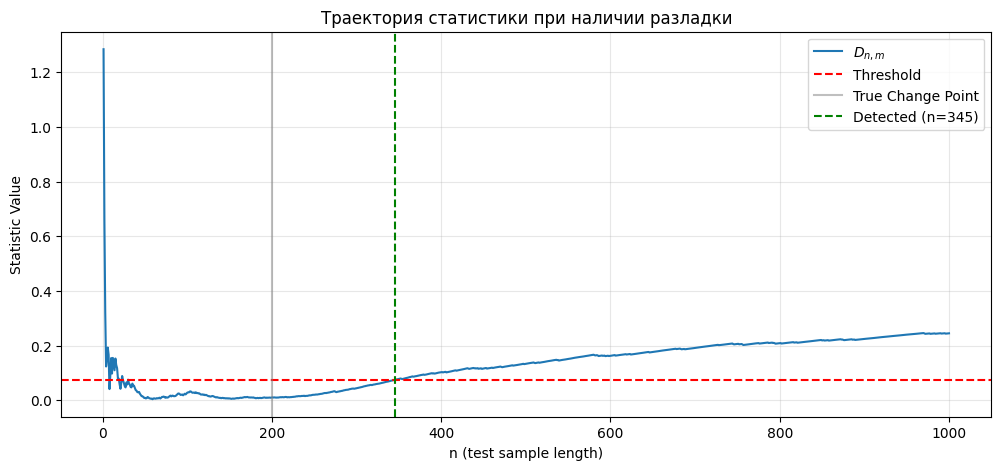

In [35]:
S_train, S_test = simulate_series(
    m_train=M_TRAIN, n_test=N_TEST, tau=200, 
    sigma1=SIGMA1, sigma2=SIGMA2
)
n_det, D_seq = detect_change(S_train, S_test, d_threshold=d_thresh)

plt.figure(figsize=(12, 5))
plt.plot(np.arange(1, len(D_seq)+1), D_seq, label=r'$D_{n,m}$')
plt.axhline(d_thresh, color='red', linestyle='--', label='Threshold')
plt.axvline(200, color='gray', alpha=0.5, label='True Change Point')

if n_det is not None:
    plt.axvline(n_det, color='green', linestyle='--', label=f'Detected (n={n_det})')

plt.xlabel('n (test sample length)')
plt.ylabel('Statistic Value')
plt.title('Траектория статистики при наличии разладки')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()